In [1]:
#Importando a biblioteca nltk

import nltk
from sentence_transformers import SentenceTransformer, SentencesDataset, util, SentencesDataset, InputExample, losses
from tqdm import tqdm 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
import pandas as pd
all_models = {}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\josed\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## BM25

 ### *BM25* Okapi 

In [2]:
#Algoritmo do BM25 Okapi

import math
import numpy as np
from multiprocessing import Pool, cpu_count

"""
All of these algorithms have been taken from the paper:
Trotmam et al, Improvements to BM25 and Language Models Examined
Here we implement all the BM25 variations mentioned. 
"""


class BM25:
    def __init__(self, corpus, tokenizer=None):
        self.corpus_size = len(corpus)
        self.avgdl = 0
        self.doc_freqs = []
        self.idf = {}
        self.doc_len = []
        self.tokenizer = tokenizer
        #Tokenizar o corpus
        if tokenizer:
            corpus = self._tokenize_corpus(corpus)

        nd = self._initialize(corpus)
        self._calc_idf(nd)

    def _initialize(self, corpus):
        nd = {}  # word -> number of documents with word
        num_doc = 0
        for document in corpus:
            self.doc_len.append(len(document))
            num_doc += len(document)

            frequencies = {}
            for word in document:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1
            self.doc_freqs.append(frequencies)

            for word, freq in frequencies.items():
                try:
                    nd[word] += 1
                except KeyError:
                    nd[word] = 1

        self.avgdl = num_doc / self.corpus_size

        return nd

    def _tokenize_corpus(self, corpus):
        pool = Pool(cpu_count())
        tokenized_corpus = pool.map(self.tokenizer, corpus)
        return tokenized_corpus

    def _calc_idf(self, nd):
        raise NotImplementedError()

    def get_scores(self, query):
        raise NotImplementedError()

    def get_batch_scores(self, query, doc_ids):
        raise NotImplementedError()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

    def get_top_n_ngram(self, score, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        pdr = np.zeros(self.corpus_size)
        alpha = 2
        for ps in score:
            pdr = np.add(pdr, alpha * ps)
            alpha -= 1

        top_n = np.argsort(pdr)[::-1][:n]
        return [documents[i] for i in top_n]

    def get_partial_score(self, query, documents):
        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        score = self.get_scores(query)

        return score

#BM25Okapi
class BM25Okapi(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=0.75, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        super().__init__(corpus, tokenizer)

    #Calculo do IDF (Inverse Document Frequency)
    def _calc_idf(self, nd):
        """
        Calculates frequencies of terms in documents and in corpus.
        This algorithm sets a floor on the idf values to eps * average_idf
        """
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps

    #Avaliar a pontuacao de todos os documentos na base
    def get_scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score.tolist()


### BM25L

In [3]:
#Implementacao do BM25L - adapta parametros para corrigir a preferencia do Okapi por documentos mais curtos

class BM25L(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=0.75, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        super().__init__(corpus, tokenizer)

    #Calculo do IDF (Inverse Document Frequency)
    def _calc_idf(self, nd):
        """
        Calculates frequencies of terms in documents and in corpus.
        This algorithm sets a floor on the idf values to eps * average_idf
        """
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size + 1) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps
    
    #Calculo do ctd
    def get_ctd(self, q_freq, b, doc_len, avg_len):
      ctd = q_freq/(1 - b + b*(doc_len)/(avg_len))
      return ctd

    #Avaliar a pontuacao de todos os documentos na base
    def get_scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)

        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            ctd = self.get_ctd(q_freq, self.b, doc_len, self.avgdl)
            score += (self.idf.get(q) or 0) * ( (ctd + 0.5) * (self.k1 + 1) /
                                               ( (ctd + 0.5) + self.k1 ))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score.tolist()

### BM25Plus

In [4]:
#BM25+
class BM25plus(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=0.75, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        super().__init__(corpus, tokenizer)

    #Calculo do IDF (Inverse Document Frequency)
    def _calc_idf(self, nd):
        """
        Calculates frequencies of terms in documents and in corpus.
        This algorithm sets a floor on the idf values to eps * average_idf
        """
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size + 1) - math.log(freq)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps

    #Avaliar pontuação de todos os documentos na base
    def get_scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)

        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * ( (q_freq * (self.k1 + 1)) /
                                               (self.k1*((1-self.b) + self.b*((doc_len)/(self.avgdl)) + q_freq) + 1))
        return score


## Pré-processamento

### Savoy

In [5]:

class Savoy:

    def __removeAllPTAccent(self, old_word):
        word = list(old_word)
        len_word = len(word)-1
        for i in range(len_word, -1, -1):
            if word[i] == 'ä':
                word[i] = 'a'
            if word[i] == 'â':
                word[i] = 'a'
            if word[i] == 'à':
                word[i] = 'a'
            if word[i] == 'á':
                word[i] = 'a'
            if word[i] == 'ã':
                word[i] = 'a'
            if word[i] == 'ê':
                word[i] = 'e'
            if word[i] == 'é':
                word[i] = 'e'
            if word[i] == 'è':
                word[i] = 'e'
            if word[i] == 'ë':
                word[i] = 'e'
            if word[i] == 'ï':
                word[i] = 'i'
            if word[i] == 'î':
                word[i] = 'i'
            if word[i] == 'ì':
                word[i] = 'i'
            if word[i] == 'í':
                word[i] = 'i'
            if word[i] == 'ü':
                word[i] = 'u'
            if word[i] == 'ú':
                word[i] = 'u'
            if word[i] == 'ù':
                word[i] = 'u'
            if word[i] == 'û':
                word[i] = 'u'
            if word[i] == 'ô':
                word[i] = 'o'
            if word[i] == 'ö':
                word[i] = 'o'
            if word[i] == 'ó':
                word[i] = 'o'
            if word[i] == 'ò':
                word[i] = 'o'
            if word[i] == 'õ':
                word[i] = 'o'
            if word[i] == 'ç':
                word[i] = 'c'

        new_word = "".join(word)
        return new_word

    def __finalVowelPortuguese(self, word):
        len_word = len(word)
        if len_word > 3:
            if word[-1] == 'e' or word[-1] == 'a' or word[-1] == 'o':
                word = word[:-1]

        return word

    def __remove_PTsuffix(self, word):
        len_word = len(word)

        if len_word > 3:
            if word[-1] == 's' and word[-2] == 'e' and (word[-3] == 'r' or word[-3] == 's' or word[-3] == 'z' or word[-3] == 'l'):
                word = word[:-2]
                return word
        if len_word > 2:
            if word[-1] == 's' and word[-2] == 'n':
                new_word = list(word)
                new_word[-2] = 'm'
                sing = "".join(new_word)
                sing = sing[:-1]
                return sing

        if len_word > 3:
            if (word[-1] == 's' and word[-2] == 'i') and (word[-3] == 'e' or word[-3] == 'é'):
                new_word = list(word)
                new_word[-3] = 'e'
                new_word[-2] = 'l'
                sing = "".join(new_word)
                sing = sing[:-1]
                return sing

        if len_word > 3:
            if word[-1] == 's' and word[-2] == 'i' and word[-3] == 'a':
                new_word = list(word)
                new_word[-2] = 'l'
                sing = "".join(new_word)
                sing = sing[:-1]
                return sing

        if len_word > 3:
            if word[-1] == 's' and word[-2] == 'i' and word[-3] == 'ó':
                new_word = list(word)
                new_word[-3] = 'o'
                new_word[-2] = 'l'
                sing = "".join(new_word)
                sing = sing[:-1]
                return sing

        if len_word > 3:
            if word[-1] == 's' and word[-2] == 'i':
                new_word = list(word)
                new_word[-1] = 'l'
                sing = "".join(new_word)
                return sing

        if len_word > 2:
            if word[-1] == 's' and word[-2] == 'e' and word[-3] == 'õ':
                new_word = list(word)
                new_word[-3] = 'ã'
                new_word[-2] = 'o'
                sing = "".join(new_word)
                sing = sing[:-1]
                return sing
            if word[-1] == 's' and word[-2] == 'e' and word[-3] == 'ã':
                new_word = list(word)
                new_word[-2] = 'o'
                sing = "".join(new_word)
                sing = sing[:-1]
                return sing

        if len_word > 5:
            if word[-1] == 'e' and word[-2] == 't' and word[-3] == 'n' and word[-4] == 'e' and word[-5] == 'm':
                word = word[:-5]
                return word

        if len_word > 2:
            if word[-1] == 's':
                word = word[:-1]

        return word

    def __normFemininPortuguese(self, word):

        len_word = len(word)

        if len_word < 3 or word[-1] != 'a':
            return word

        if len_word > 6:

            if word[-2] == 'h' and word[-3] == 'n' and word[-4] == 'i':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 'c' and word[-3] == 'a' and word[-4] == 'i':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 'r' and word[-3] == 'i' and word[-4] == 'e':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

        if len_word > 5:
            if word[-2] == 'n' and word[-3] == 'o':
                new_word = list(word)
                new_word[-3] = 'ã'
                new_word[-2] = 'o'
                masc = "".join(new_word)
                masc = masc[:-1]
                return masc

            if word[-2] == 'r' and word[-3] == 'o':
                word = word[:-1]
                return word

            if word[-2] == 's' and word[-3] == 'o':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 's' and word[-3] == 'e':
                new_word = list(word)
                new_word[-3] = 'ê'
                masc = "".join(new_word)
                masc = masc[:-1]
                return masc

            if word[-2] == 'c' and word[-3] == 'i':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 'd' and word[-3] == 'i':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 'd' and word[-3] == 'a':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 'v' and word[-3] == 'i':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 'm' and word[-3] == 'a':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

            if word[-2] == 'n':
                new_word = list(word)
                new_word[-1] = 'o'
                masc = "".join(new_word)
                return masc

        return word

    def stem(self, word):
        len_word = len(word)
        if len_word > 2:
            word = self.__remove_PTsuffix(word)
            word = self.__normFemininPortuguese(word)
            word = self.__finalVowelPortuguese(word)
            word = self.__removeAllPTAccent(word)

        return word


### Aplicando pré-processamento

In [6]:
from nltk.tokenize import word_tokenize
from string import punctuation
import nltk
from unicodedata import normalize
from nltk.stem import RSLPStemmer
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer

# Remove os acentos de uma string
def _remove_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

# Tokenizador
def preprocess0(txt):   
    terms = word_tokenize(txt)
    # tokenizer = RegexpTokenizer('\w+')
    # terms = tokenizer.tokenize(txt.lower())
 #   terms = [word for word in terms if word not in stopwords]

    return terms

# Remoção de stopwords + acentuação
def preprocess2(txt):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))
    
    # terms = word_tokenize(txt.lower())
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [word for word in terms if word not in stopwords]

    return terms

# Remoção de stopwords + acentuação + steming
def preprocess3(txt):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))

    # stemmer = RSLPStemmer()
    # terms = word_tokenize(txt.lower())
    stemmer = Savoy()
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [stemmer.stem(word) for word in terms if word not in stopwords]
    return terms

# Remoção de stopwords + acentuação + n-gram
def preprocess_ngram(txt, n):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))

    # terms = word_tokenize(txt.lower())
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [word for word in terms if word not in stopwords]

    ngram = list(ngrams(terms, n))

    return ngram

# Remoção de stopwords + acentuação + steming + n-gram
def preprocess_ngram_stem(txt, n):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))

    # stemmer = RSLPStemmer()
    # terms = word_tokenize(txt.lower())
    stemmer = Savoy()
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [stemmer.stem(word) for word in terms if word not in stopwords]

    ngram = list(ngrams(terms, n))

    return ngram

In [7]:
df = pd.DataFrame()
for i in range(0,5):
    df = pd.concat([df, pd.read_csv(f"../../../Scripts/propor2024/base_20230428_douglas-bill_corpus-part{i}.csv")])

In [8]:
df.shape

(56603, 11)

In [8]:
a = df['txtInteiroTeorLimpo'].apply(lambda x: len(preprocess0(x)))
b = df['resumo'].apply(lambda x: len(preprocess0(x)))

In [9]:
new = df[['txtNome']]

In [10]:
len([e for e in a if e <512])

17322

In [11]:
num_linhas = 0

for num_palavras in b:
    if num_palavras > 2048:
        num_linhas += 1

porcentagem = (num_linhas / len(b)) * 100

print(f'{porcentagem:.2f}% das linhas têm mais de 512 palavras.')

0.00% das linhas têm mais de 512 palavras.


In [12]:
max(b)

367

In [13]:
new['txtInteiroTeorLimpo'] = a

C:\Users\josed\AppData\Local\Temp\ipykernel_19040\1030275560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['txtInteiroTeorLimpo'] = a


In [14]:
new.to_excel('new_tokenscount.xlsx')

In [15]:
# Obtem o nome do texto no df
def get_name(df, doc,column_data):
    return str(df[df[column_data]==doc].txtNome.to_numpy()[0]).strip()
    #return str(df[df.content==doc].name.to_numpy()[0]).strip()

In [16]:
def evaluate(df, arr_assunto, top_k, all_preprocessing, column_data):
    data = df[column_data].to_numpy()
    if all_preprocessing:
        tokenized_corpus3 = [preprocess3(doc) for doc in data]                      #Stopwords + Acentuação + Stemming
        bigram_corpus_stem = [preprocess_ngram_stem(doc, 2) for doc in data]        #Stopwords + Acentuação + Stemming + Bigram
        bm25L_bigram_stem = BM25L(bigram_corpus_stem)           #Stopwords + Acentuação + Stemming + Bigram             #Tokenizer
    else:
        tokenized_corpus3 = [preprocess0(doc) for doc in data]         
    bm25L_tokenstem = BM25L(tokenized_corpus3)              #Stopwords + Acentuação + Stemming

    y,X = arr_assunto[:,0],arr_assunto[:,1]
    y = [i.strip() for i in y]

    '''
    Obter o resultado do BM25 para cada query
    '''
    #Listas com os n documentos mais relevantes para cada versao do BM25
    labels_nsL = list()             #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
    l_v = list()
    for l,x in zip((y),X):
        if all_preprocessing:
            tokenized_query3 = preprocess3(x)                   #Stopwords + Acentuação + Stemming
            tokenized_queryb_stem = preprocess_ngram_stem(x,2)  #Stopwords + Acentuação + Stemming + Bigram
        else:
            tokenized_query3 = preprocess0(x)                   #Tokenizer
        #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
        scores_stem_l = list()
        scores_stem_l.append(bm25L_tokenstem.get_partial_score(tokenized_query3, data))
        if all_preprocessing:
            scores_stem_l.append(bm25L_bigram_stem.get_partial_score(tokenized_queryb_stem, data))
        top_n_stem_l = bm25L_tokenstem.get_top_n_ngram(scores_stem_l, data, n=top_k)


        labelsnsL = [get_name(df,d,column_data) for d in top_n_stem_l]              #L
        #Adicionar os resultados da query as listas
        labels_nsL.append(labelsnsL)    #L

        #Adicionar resposta esperada a lista
        l_v.append(l)

    res_nsL = list()                #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
    for k in range(1, top_k+1):
        resultsnsL = list()         #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
        for i in range(len(l_v)):
            if (l_v[i] in labels_nsL[i][:k]):
                resultsnsL.append(1)
            else:
                resultsnsL.append(0)
        res_nsL.append(sum(resultsnsL)/len(resultsnsL))

    return res_nsL[-1]

In [36]:
def evaluate_model(corpus_embeddings, query_embedding):
    # corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
    res_vector = list()
    try:
        # query_embedding = model.encode(query, convert_to_tensor=True)
        cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
        # top_results = torch.topk(cos_scores, k=top_k)

        # if torch.cuda.is_available():
        #     top_resuts_txt = [get_name(df, txt, in_field=column_data, out_field="txtNome").strip() for txt in corpus[top_results[1].cpu().numpy()]]
        # else:
        #     top_resuts_txt = [get_name(df, txt, in_field=column_data, out_field="txtNome").strip() for txt in corpus[top_results[1].numpy()]]

        # res_vector.append([get_name(df_assunto, query, "TxtAssunto", "NÚMERO-PROPOSIÇÃOSILEG").strip(), top_resuts_txt])
    except Exception as e:
        print(f"ERRO ao realizar encoding:{e}")
        pass
    return cos_scores.numpy()

In [35]:
a = np.array([1,2,3])
b = np.array([4,5,6])
c = a +b
print(c)

[5 7 9]


In [48]:
def evaluate(df, arr_assunto, top_k, all_preprocessing, column_data):
    data = df[column_data].to_numpy()
    if all_preprocessing:
        tokenized_corpus3 = [preprocess3(doc) for doc in data]                      #Stopwords + Acentuação + Stemming
        bigram_corpus_stem = [preprocess_ngram_stem(doc, 2) for doc in data]        #Stopwords + Acentuação + Stemming + Bigram
        bm25L_bigram_stem = BM25L(bigram_corpus_stem)           #Stopwords + Acentuação + Stemming + Bigram             #Tokenizer
    else:
        tokenized_corpus3 = [preprocess0(doc) for doc in data]         
    bm25L_tokenstem = BM25L(tokenized_corpus3)              #Stopwords + Acentuação + Stemming
    
    y,X = arr_assunto[:,0],arr_assunto[:,1]
    y = [i.strip() for i in y]
    model = SentenceTransformer("sentence-transformers/LabSE")
    corpus_embeddings = model.encode(data, convert_to_tensor=True)

    '''
    Obter o resultado do BM25 para cada query
    '''
    #Listas com os n documentos mais relevantes para cada versao do BM25
    labels_nsL = list()             #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
    l_v = list()
    for l,x in zip((y),X):
        if all_preprocessing:
            tokenized_query3 = preprocess3(x)                   #Stopwords + Acentuação + Stemming
            tokenized_queryb_stem = preprocess_ngram_stem(x,2)  #Stopwords + Acentuação + Stemming + Bigram
        else:
            tokenized_query3 = preprocess0(x)                   #Tokenizer
        query_embedding = model.encode(x, convert_to_tensor=True)
        #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
        # scores_stem_l = list()
        scores = bm25L_tokenstem.get_partial_score(tokenized_query3, data)
        scores_normalized = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        # scores_stem_l.append(scores)
        print(scores_normalized)
        print(len(scores_normalized))
        if all_preprocessing:
            scores_bi = bm25L_bigram_stem.get_partial_score(tokenized_queryb_stem, data)
            scores_bi_normalized = (scores_bi - np.min(scores_bi)) / (np.max(scores_bi) - np.min(scores_bi))
            print(scores_bi_normalized)
            print(len(scores_bi_normalized))
            # scores_stem_l.append(scores_bi)
        # top_n_stem_l = bm25L_tokenstem.get_top_n_ngram(scores_stem_l, data, n=top_k)
        
        
        
        
        model_score = evaluate_model(query_embedding=query_embedding, corpus_embeddings=corpus_embeddings)
        print(model_score)
        print(len(model_score))
        
        if all_preprocessing:
            final_score = scores_normalized + scores_bi_normalized + model_score
        else:
            final_score = scores_normalized + model_score
            
        print(final_score)
        print(len(final_score))
        return final_score

        labelsnsL = [get_name(df,d,column_data) for d in top_n_stem_l]              #L
        #Adicionar os resultados da query as listas
        labels_nsL.append(labelsnsL)    #L

        #Adicionar resposta esperada a lista
        l_v.append(l)

    res_nsL = list()                #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
    for k in range(1, top_k+1):
        resultsnsL = list()         #Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
        for i in range(len(l_v)):
            if (l_v[i] in labels_nsL[i][:k]):
                resultsnsL.append(1)
            else:
                resultsnsL.append(0)
        res_nsL.append(sum(resultsnsL)/len(resultsnsL))

    return res_nsL[-1]

In [49]:
'''
Verificar se a solicitação correta esta entre os k primeiro documentos retornados (de 1 ate 100)
'''
top_k = 20
column_data = 'resumo'
runs = 5

for i in tqdm(range(0, runs)):
    element = f'{column_data}_{i}'
    df = pd.read_csv(f"../../propor2024/base_20230428_douglas-bill_corpus-part{i}.csv")
    df_assunto = pd.read_csv(f"../../propor2024/dados-conle-anonimizado-job_request-part{i}.csv", encoding="utf-8").to_numpy()
    # raw = evaluate(df,df_assunto,top_k, False,column_data)
    processed = evaluate(df,df_assunto,top_k, True,column_data)
    break
    all_models[element] = (raw, processed)
    tqdm.write(f'BM25 raw Recall: {round(raw*100,2)} Jurix Recall:{round(processed*100,2)}')

recalls_raw = [all_models[e][0] for e in all_models]
recalls_processed = [all_models[e][1] for e in all_models]
print(f'BM25L Raw data {recalls_raw} --> Média: {round(np.average(recalls_raw)*100,2)}. Desvio Padrão: {np.std(recalls_raw)}')
print(f'BM25L preprocessed {recalls_processed} --> Média: {round(np.average(recalls_processed)*100,2)}. Desvio Padrão: {np.std(recalls_processed)}')


  0%|          | 0/5 [33:42<?, ?it/s]

[0.         0.14259792 0.         ... 0.         0.         0.        ]
11321
[0. 0. 0. ... 0. 0. 0.]
11321
tensor([0.1643, 0.1990, 0.1310,  ..., 0.1017, 0.2573, 0.1698])
11321


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

# Main

In [14]:
'''
Verificar se a solicitação correta esta entre os k primeiro documentos retornados (de 1 ate 100)
'''
top_k = 20
column_data = 'hibrido'
runs = 5

for i in tqdm(range(0, runs)):
    element = f'{column_data}_{i}'
    df = pd.read_csv(f"../../propor2024/base_20230428_douglas-bill_corpus-part{i}.csv")
    if column_data == 'hibrido':
        df['hibrido'] = df['txtIndexacao'] + df['txtInteiroTeorLimpo']
    df_assunto = pd.read_csv(f"../../propor2024/dados-conle-anonimizado-job_request-part{i}.csv", encoding="utf-8").to_numpy()
    raw = evaluate(df,df_assunto,top_k, False,column_data)
    processed = evaluate(df,df_assunto,top_k, True,column_data)
    all_models[element] = (raw, processed)
    tqdm.write(f'BM25 raw Recall: {round(raw*100,2)} Jurix Recall:{round(processed*100,2)}')

recalls_raw = [all_models[e][0] for e in all_models]
recalls_processed = [all_models[e][1] for e in all_models]
print(f'BM25L Raw data {recalls_raw} --> Média: {round(np.average(recalls_raw)*100,2)}. Desvio Padrão: {np.std(recalls_raw)}')
print(f'BM25L preprocessed {recalls_processed} --> Média: {round(np.average(recalls_processed)*100,2)}. Desvio Padrão: {np.std(recalls_processed)}')



 20%|██        | 1/5 [04:01<16:04, 241.08s/it]

BM25 raw Recall: 57.78 Jurix Recall:66.67


 40%|████      | 2/5 [08:38<13:08, 262.69s/it]

BM25 raw Recall: 75.68 Jurix Recall:82.43


 60%|██████    | 3/5 [13:51<09:30, 285.29s/it]

BM25 raw Recall: 76.12 Jurix Recall:86.57


 80%|████████  | 4/5 [18:08<04:34, 274.28s/it]

BM25 raw Recall: 79.25 Jurix Recall:90.57


100%|██████████| 5/5 [22:27<00:00, 269.40s/it]

BM25 raw Recall: 78.57 Jurix Recall:87.5
BM25L Raw data [0.5333333333333333, 0.6351351351351351, 0.5671641791044776, 0.6226415094339622, 0.5535714285714286, 0.5777777777777777, 0.7567567567567568, 0.7611940298507462, 0.7924528301886793, 0.7857142857142857] --> Média: 65.86. Desvio Padrão: 0.09884027084880588
BM25L preprocessed [0.6, 0.7837837837837838, 0.7910447761194029, 0.7547169811320755, 0.7321428571428571, 0.6666666666666666, 0.8243243243243243, 0.8656716417910447, 0.9056603773584906, 0.875] --> Média: 77.99. Desvio Padrão: 0.09079096560216078


In [23]:
for i in ['txtEmenta','txtIndexacao','txtInteiroTeor','txtInteiroTeorLimpo','resumo']:
    print(i)
    print(f"RAW: {[all_models[e][0] for e in all_models if e.startswith(i)]}")
    print(f"Prosseced: {[all_models[e][1] for e in all_models if e.startswith(i)]}")

txtEmenta
RAW: [0.35555555555555557, 0.5135135135135135, 0.4925373134328358, 0.5283018867924528, 0.5535714285714286]
Prosseced: [0.4888888888888889, 0.6216216216216216, 0.7164179104477612, 0.6415094339622641, 0.6428571428571429]
txtIndexacao
RAW: [0.3111111111111111, 0.36486486486486486, 0.31343283582089554, 0.3584905660377358, 0.2857142857142857]
Prosseced: [0.4888888888888889, 0.6756756756756757, 0.6268656716417911, 0.6981132075471698, 0.6428571428571429]
txtInteiroTeor
RAW: [0.5777777777777777, 0.7702702702702703, 0.746268656716418, 0.7924528301886793, 0.7321428571428571]
Prosseced: [0.6666666666666666, 0.8243243243243243, 0.8656716417910447, 0.8867924528301887, 0.8571428571428571]
txtInteiroTeorLimpo
RAW: []
Prosseced: []
resumo
RAW: [0.5333333333333333, 0.6351351351351351, 0.5671641791044776, 0.6226415094339622, 0.5535714285714286]
Prosseced: [0.6, 0.7837837837837838, 0.7910447761194029, 0.7547169811320755, 0.7321428571428571]


In [24]:
all_models

{'resumo_0': (0.5333333333333333, 0.6),
 'resumo_1': (0.6351351351351351, 0.7837837837837838),
 'resumo_2': (0.5671641791044776, 0.7910447761194029),
 'resumo_3': (0.6226415094339622, 0.7547169811320755),
 'resumo_4': (0.5535714285714286, 0.7321428571428571),
 'hibrido_0': (0.5777777777777777, 0.6666666666666666),
 'hibrido_1': (0.7567567567567568, 0.8243243243243243),
 'hibrido_2': (0.7611940298507462, 0.8656716417910447),
 'hibrido_3': (0.7924528301886793, 0.9056603773584906),
 'hibrido_4': (0.7857142857142857, 0.875),
 'txtEmenta_0': (0.35555555555555557, 0.4888888888888889),
 'txtEmenta_1': (0.5135135135135135, 0.6216216216216216),
 'txtEmenta_2': (0.4925373134328358, 0.7164179104477612),
 'txtEmenta_3': (0.5283018867924528, 0.6415094339622641),
 'txtEmenta_4': (0.5535714285714286, 0.6428571428571429),
 'txtIndexacao_0': (0.3111111111111111, 0.4888888888888889),
 'txtIndexacao_1': (0.36486486486486486, 0.6756756756756757),
 'txtIndexacao_2': (0.31343283582089554, 0.6268656716417911

In [15]:
'''
Verificar se a solicitação correta esta entre os k primeiro documentos retornados (de 1 ate 100)
'''
top_k = 20
column_data = 'txtEmenta'
runs = 5

for i in tqdm(range(0, runs)):
    element = f'{column_data}_{i}'
    df = pd.read_csv(f"../../propor2024/base_20230428_douglas-bill_corpus-part{i}.csv")
    df_assunto = pd.read_csv(f"../../propor2024/dados-conle-anonimizado-job_request-part{i}.csv", encoding="utf-8").to_numpy()
    raw = evaluate(df,df_assunto,top_k, False,column_data)
    processed = evaluate(df,df_assunto,top_k, True,column_data)
    all_models[element] = (raw, processed)
    tqdm.write(f'BM25 raw Recall: {round(raw*100,2)} Jurix Recall:{round(processed*100,2)}')

recalls_raw = [all_models[e][0] for e in all_models]
recalls_processed = [all_models[e][1] for e in all_models]
print(f'BM25L Raw data {recalls_raw} --> Média: {round(np.average(recalls_raw)*100,2)}. Desvio Padrão: {np.std(recalls_raw)}')
print(f'BM25L preprocessed {recalls_processed} --> Média: {round(np.average(recalls_processed)*100,2)}. Desvio Padrão: {np.std(recalls_processed)}')


 20%|██        | 1/5 [00:24<01:37, 24.29s/it]

BM25 raw Recall: 35.56 Jurix Recall:48.89


 40%|████      | 2/5 [01:05<01:42, 34.21s/it]

BM25 raw Recall: 51.35 Jurix Recall:62.16


 60%|██████    | 3/5 [01:43<01:11, 35.87s/it]

BM25 raw Recall: 49.25 Jurix Recall:71.64


 80%|████████  | 4/5 [02:18<00:35, 35.71s/it]

BM25 raw Recall: 52.83 Jurix Recall:64.15


100%|██████████| 5/5 [02:56<00:00, 35.27s/it]

BM25 raw Recall: 55.36 Jurix Recall:64.29
BM25L Raw data [0.5333333333333333, 0.6351351351351351, 0.5671641791044776, 0.6226415094339622, 0.5535714285714286, 0.5777777777777777, 0.7567567567567568, 0.7611940298507462, 0.7924528301886793, 0.7857142857142857, 0.35555555555555557, 0.5135135135135135, 0.4925373134328358, 0.5283018867924528, 0.5535714285714286] --> Média: 60.19. Desvio Padrão: 0.12056085865790536
BM25L preprocessed [0.6, 0.7837837837837838, 0.7910447761194029, 0.7547169811320755, 0.7321428571428571, 0.6666666666666666, 0.8243243243243243, 0.8656716417910447, 0.9056603773584906, 0.875, 0.4888888888888889, 0.6216216216216216, 0.7164179104477612, 0.6415094339622641, 0.6428571428571429] --> Média: 72.74. Desvio Padrão: 0.11334771455999448


In [16]:
top_k = 20
column_data = 'txtIndexacao'
runs = 5

for i in tqdm(range(0, runs)):
    element = f'{column_data}_{i}'
    df = pd.read_csv(f"../../propor2024/base_20230428_douglas-bill_corpus-part{i}.csv")
    df_assunto = pd.read_csv(f"../../propor2024/dados-conle-anonimizado-job_request-part{i}.csv", encoding="utf-8").to_numpy()
    raw = evaluate(df,df_assunto,top_k, False,column_data)
    processed = evaluate(df,df_assunto,top_k, True,column_data)
    all_models[element] = (raw, processed)
    tqdm.write(f'BM25 raw Recall: {round(raw*100,2)} Jurix Recall:{round(processed*100,2)}')

recalls_raw = [all_models[e][0] for e in all_models]
recalls_processed = [all_models[e][1] for e in all_models]
print(f'BM25L Raw data {recalls_raw} --> Média: {round(np.average(recalls_raw)*100,2)}. Desvio Padrão: {np.std(recalls_raw)}')
print(f'BM25L preprocessed {recalls_processed} --> Média: {round(np.average(recalls_processed)*100,2)}. Desvio Padrão: {np.std(recalls_processed)}')


 20%|██        | 1/5 [00:25<01:42, 25.61s/it]

BM25 raw Recall: 31.11 Jurix Recall:48.89


 40%|████      | 2/5 [01:10<01:50, 36.87s/it]

BM25 raw Recall: 36.49 Jurix Recall:67.57


 60%|██████    | 3/5 [01:56<01:22, 41.04s/it]

BM25 raw Recall: 31.34 Jurix Recall:62.69


 80%|████████  | 4/5 [02:34<00:39, 39.82s/it]

BM25 raw Recall: 35.85 Jurix Recall:69.81


100%|██████████| 5/5 [03:14<00:00, 38.98s/it]

BM25 raw Recall: 28.57 Jurix Recall:64.29
BM25L Raw data [0.5333333333333333, 0.6351351351351351, 0.5671641791044776, 0.6226415094339622, 0.5535714285714286, 0.5777777777777777, 0.7567567567567568, 0.7611940298507462, 0.7924528301886793, 0.7857142857142857, 0.35555555555555557, 0.5135135135135135, 0.4925373134328358, 0.5283018867924528, 0.5535714285714286, 0.3111111111111111, 0.36486486486486486, 0.31343283582089554, 0.3584905660377358, 0.2857142857142857] --> Média: 53.31. Desvio Padrão: 0.1591616396310393
BM25L preprocessed [0.6, 0.7837837837837838, 0.7910447761194029, 0.7547169811320755, 0.7321428571428571, 0.6666666666666666, 0.8243243243243243, 0.8656716417910447, 0.9056603773584906, 0.875, 0.4888888888888889, 0.6216216216216216, 0.7164179104477612, 0.6415094339622641, 0.6428571428571429, 0.4888888888888889, 0.6756756756756757, 0.6268656716417911, 0.6981132075471698, 0.6428571428571429] --> Média: 70.21. Desvio Padrão: 0.1134955648439407


In [17]:
top_k = 20
column_data = 'txtInteiroTeor'
runs = 5

for i in tqdm(range(0, runs)):
    element = f'{column_data}_{i}'
    df = pd.read_csv(f"../../propor2024/base_20230428_douglas-bill_corpus-part{i}.csv")
    df_assunto = pd.read_csv(f"../../propor2024/dados-conle-anonimizado-job_request-part{i}.csv", encoding="utf-8").to_numpy()
    raw = evaluate(df,df_assunto,top_k, False,column_data)
    processed = evaluate(df,df_assunto,top_k, True,column_data)
    all_models[element] = (raw, processed)
    tqdm.write(f'BM25 raw Recall: {round(raw*100,2)} Jurix Recall:{round(processed*100,2)}')

recalls_raw = [all_models[e][0] for e in all_models]
recalls_processed = [all_models[e][1] for e in all_models]
print(f'BM25L Raw data {recalls_raw} --> Média: {round(np.average(recalls_raw)*100,2)}. Desvio Padrão: {np.std(recalls_raw)}')
print(f'BM25L preprocessed {recalls_processed} --> Média: {round(np.average(recalls_processed)*100,2)}. Desvio Padrão: {np.std(recalls_processed)}')


 20%|██        | 1/5 [03:44<14:58, 224.54s/it]

BM25 raw Recall: 57.78 Jurix Recall:66.67


 40%|████      | 2/5 [07:58<12:04, 241.64s/it]

BM25 raw Recall: 77.03 Jurix Recall:82.43


 60%|██████    | 3/5 [12:16<08:18, 249.05s/it]

BM25 raw Recall: 74.63 Jurix Recall:86.57


 80%|████████  | 4/5 [16:07<04:02, 242.25s/it]

BM25 raw Recall: 79.25 Jurix Recall:88.68


100%|██████████| 5/5 [20:16<00:00, 243.25s/it]

BM25 raw Recall: 73.21 Jurix Recall:85.71
BM25L Raw data [0.5333333333333333, 0.6351351351351351, 0.5671641791044776, 0.6226415094339622, 0.5535714285714286, 0.5777777777777777, 0.7567567567567568, 0.7611940298507462, 0.7924528301886793, 0.7857142857142857, 0.35555555555555557, 0.5135135135135135, 0.4925373134328358, 0.5283018867924528, 0.5535714285714286, 0.3111111111111111, 0.36486486486486486, 0.31343283582089554, 0.3584905660377358, 0.2857142857142857, 0.5777777777777777, 0.7702702702702703, 0.746268656716418, 0.7924528301886793, 0.7321428571428571] --> Média: 57.13. Desvio Padrão: 0.16502045413963942
BM25L preprocessed [0.6, 0.7837837837837838, 0.7910447761194029, 0.7547169811320755, 0.7321428571428571, 0.6666666666666666, 0.8243243243243243, 0.8656716417910447, 0.9056603773584906, 0.875, 0.4888888888888889, 0.6216216216216216, 0.7164179104477612, 0.6415094339622641, 0.6428571428571429, 0.4888888888888889, 0.6756756756756757, 0.6268656716417911, 0.6981132075471698, 0.6428571428571

In [31]:
top_k = 20
column_data = 'txtInteiroTeorLimpo'
runs = 5
all_models = dict()

for i in tqdm(range(0, runs)):
    element = f'{column_data}_{i}'
    df = pd.read_csv(f"../../propor2024/base_20230428_douglas-bill_corpus-part{i}.csv")
    df_assunto = pd.read_csv(f"../../propor2024/dados-conle-anonimizado-job_request-part{i}.csv", encoding="utf-8").to_numpy()
    raw = evaluate(df,df_assunto,top_k, False,column_data)
    processed = evaluate(df,df_assunto,top_k, True,column_data)
    all_models[element] = (raw, processed)
    tqdm.write(f'BM25 raw Recall: {round(raw*100,2)} Jurix Recall:{round(processed*100,2)}')

recalls_raw = [all_models[e][0] for e in all_models]
recalls_processed = [all_models[e][1] for e in all_models]
print(f'BM25L Raw data {recalls_raw} --> Média: {round(np.average(recalls_raw)*100,2)}. Desvio Padrão: {np.std(recalls_raw)}')
print(f'BM25L preprocessed {recalls_processed} --> Média: {round(np.average(recalls_processed)*100,2)}. Desvio Padrão: {np.std(recalls_processed)}')



 20%|██        | 1/5 [03:41<14:46, 221.59s/it]

BM25 raw Recall: 55.56 Jurix Recall:66.67


 40%|████      | 2/5 [07:52<11:57, 239.07s/it]

BM25 raw Recall: 77.03 Jurix Recall:82.43


 60%|██████    | 3/5 [12:14<08:19, 249.51s/it]

BM25 raw Recall: 74.63 Jurix Recall:86.57


 80%|████████  | 4/5 [16:07<04:03, 243.05s/it]

BM25 raw Recall: 79.25 Jurix Recall:88.68


100%|██████████| 5/5 [20:18<00:00, 243.67s/it]

BM25 raw Recall: 76.79 Jurix Recall:85.71
BM25L Raw data [0.5555555555555556, 0.7702702702702703, 0.746268656716418, 0.7924528301886793, 0.7678571428571429] --> Média: 72.65. Desvio Padrão: 0.08670504793122462
BM25L preprocessed [0.6666666666666666, 0.8243243243243243, 0.8656716417910447, 0.8867924528301887, 0.8571428571428571] --> Média: 82.01. Desvio Padrão: 0.07931766743993746


# Old

In [27]:
'''
Exibe a acuracia do algoritmo
'''
print("Stopwords + Acentuação + Stemming + Unigram + Bigram (Okapi)")
print(f"Quantidade encontrada: {sum(resultsns)}")
print(f"Quantidade total: {len(arr_assunto)}")
print(f"Acurácia 10 docs: {res_ns[9]}")
print(f"Acurácia 20 docs: {res_ns[19]}")
print(f"Acurácia {top_k} docs: {res_ns[-1]}\n\n")

print("Stopwords + Acentuação + Stemming + Unigram + Bigram (L)")
print(f"Quantidade encontrada: {sum(resultsnsL)}")
print(f"Quantidade total: {len(arr_assunto)}")
print(f"Acurácia 10 docs: {res_nsL[9]}")
print(f"Acurácia 20 docs: {res_nsL[19]}")
print(f"Acurácia {top_k} docs: {res_nsL[-1]}\n\n")

print("Stopwords + Acentuação + Stemming + Unigram + Bigram (Plus)")
print(f"Quantidade encontrada: {sum(resultsnsP)}")
print(f"Quantidade total: {len(arr_assunto)}")
print(f"Acurácia 10 docs: {res_nsP[9]}")
print(f"Acurácia 20 docs: {res_nsP[19]}")
print(f"Acurácia {top_k} docs: {res_nsP[-1]}\n\n")

Stopwords + Acentuação + Stemming + Unigram + Bigram (Okapi)
Quantidade encontrada: 17
Quantidade total: 295
Acurácia 10 docs: 0.05423728813559322
Acurácia 20 docs: 0.05423728813559322
Acurácia 100 docs: 0.0576271186440678


Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
Quantidade encontrada: 17
Quantidade total: 295
Acurácia 10 docs: 0.05423728813559322
Acurácia 20 docs: 0.05423728813559322
Acurácia 100 docs: 0.0576271186440678


Stopwords + Acentuação + Stemming + Unigram + Bigram (Plus)
Quantidade encontrada: 17
Quantidade total: 295
Acurácia 10 docs: 0.05423728813559322
Acurácia 20 docs: 0.05423728813559322
Acurácia 100 docs: 0.0576271186440678




Stopwords + Acentuação + Stemming + Unigram + Bigram (Okapi)<br>
Quantidade encontrada: 211<br>
Quantidade total: 295<br>
Acurácia 10 docs: 0.6067796610169491<br>
Acurácia 100 docs: 0.7152542372881356<br>


Stopwords + Acentuação + Stemming + Unigram + Bigram (L)<br>
Quantidade encontrada: 208<br>
Quantidade total: 295<br>
Acurácia 10 docs: 0.6033898305084746<br>
Acurácia 100 docs: 0.7050847457627119<br>


Stopwords + Acentuação + Stemming + Unigram + Bigram (Plus)<br>
Quantidade encontrada: 209<br>
Quantidade total: 295<br>
Acurácia 10 docs: 0.6135593220338983<br>
Acurácia 100 docs: 0.7084745762711865<br>

In [28]:
column_data

'imgArquivoTeorPDF'

In [27]:
with open(f"../models/{column_data+'+'+column_data2 if column_data2!=None else column_data}/bm25_2019_Okapi{'0' if not all_preprocessing else ''}.npy", "wb") as f:
    np.save(f,res_ns)
with open(f"../models/{column_data+'+'+column_data2 if column_data2!=None else column_data}/bm25_2019_Plus{'0' if not all_preprocessing else ''}.npy", "wb") as f:
    np.save(f,res_nsP)
with open(f"../models/{column_data+'+'+column_data2 if column_data2!=None else column_data}/bm25_2019_L{'0' if not all_preprocessing else ''}.npy", "wb") as f:
    np.save(f,res_nsL)


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

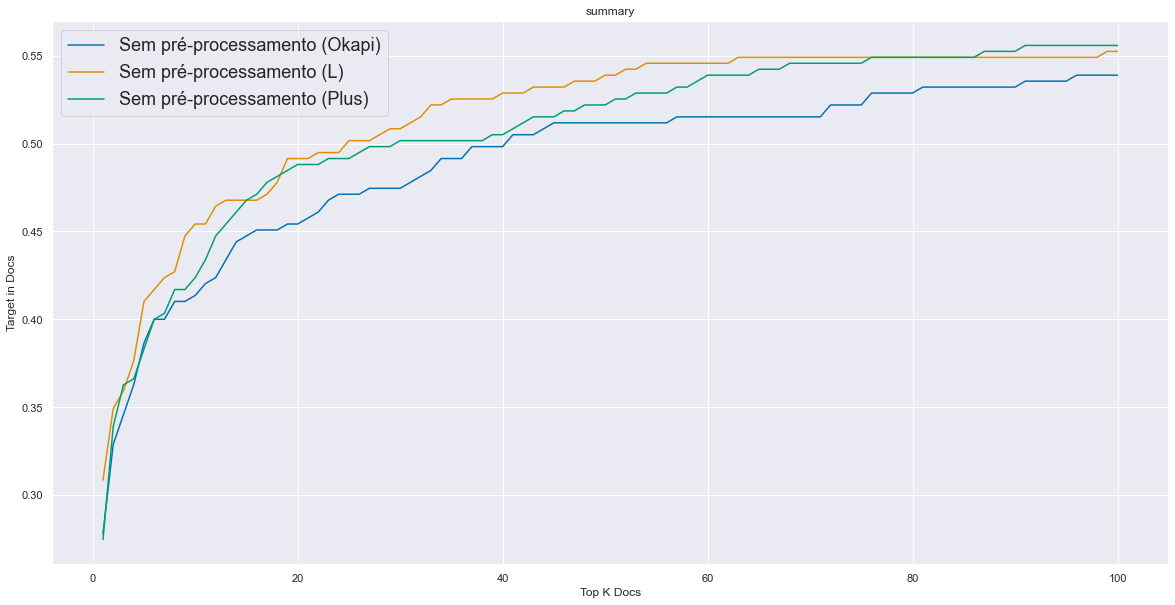

In [28]:
sns.set(palette='colorblind')
plt.figure(figsize=(20,10))
plt.rc('legend', fontsize=18)

plt.plot(np.arange(1,top_k+1), res_ns, label=f"{'Stopwords + Acentuação + Stemming + Unigram + Bigram' if all_preprocessing else 'Sem pré-processamento'} (Okapi)")
plt.plot(np.arange(1,top_k+1), res_nsL, label=f"{'Stopwords + Acentuação + Stemming + Unigram + Bigram' if all_preprocessing else 'Sem pré-processamento'} (L)")
plt.plot(np.arange(1,top_k+1), res_nsP, label=f"{'Stopwords + Acentuação + Stemming + Unigram + Bigram' if all_preprocessing else 'Sem pré-processamento'} (Plus)")

plt.title(column_data+'+'+column_data2 if column_data2!=None else column_data)
plt.legend()
plt.ylabel("Target in Docs")
plt.xlabel("Top K Docs")
plt.show()


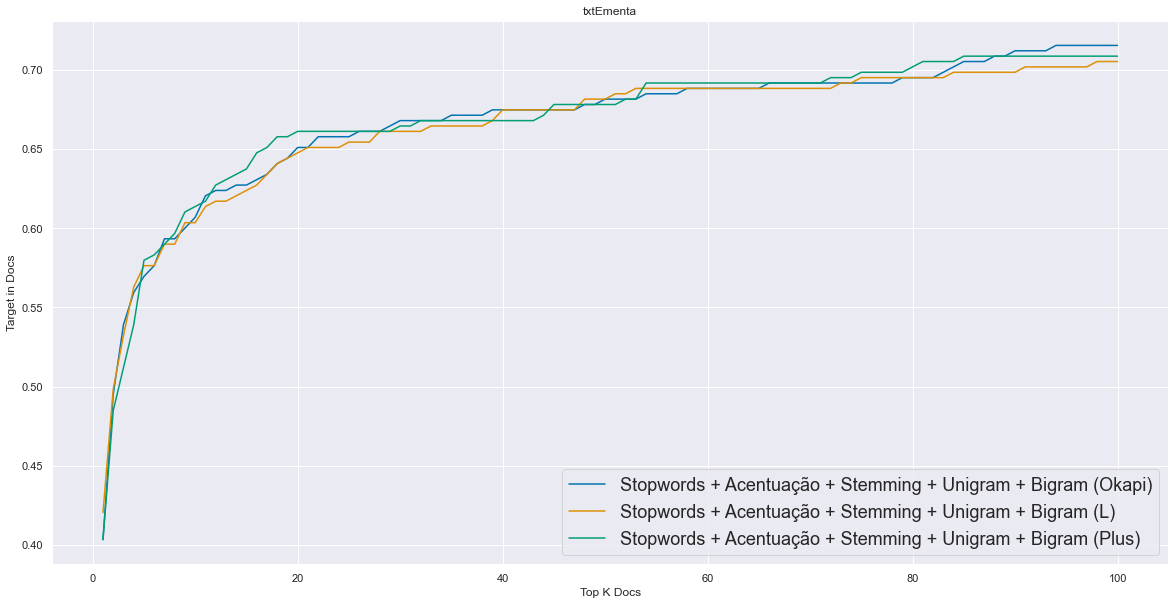

In [30]:
sns.set(palette='colorblind')
plt.figure(figsize=(20,10))
plt.rc('legend', fontsize=18)

plt.plot(np.arange(1,top_k+1), res_ns, label=f"{'Stopwords + Acentuação + Stemming + Unigram + Bigram' if all_preprocessing else 'Sem pré-processamento'} (Okapi)")
plt.plot(np.arange(1,top_k+1), res_nsL, label=f"{'Stopwords + Acentuação + Stemming + Unigram + Bigram' if all_preprocessing else 'Sem pré-processamento'} (L)")
plt.plot(np.arange(1,top_k+1), res_nsP, label=f"{'Stopwords + Acentuação + Stemming + Unigram + Bigram' if all_preprocessing else 'Sem pré-processamento'} (Plus)")

plt.title(column_data+'+'+column_data2 if column_data2!=None else column_data)
plt.legend()
plt.ylabel("Target in Docs")
plt.xlabel("Top K Docs")
plt.show()



In [46]:
df2 = df[['txtNome','txtEmenta']]

In [51]:
df2['jurix'] = pd.DataFrame([' '.join(e) for e in tokenized_corpus3])

C:\Users\josed\AppData\Local\Temp\ipykernel_14128\3090783680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['jurix'] = pd.DataFrame([' '.join(e) for e in tokenized_corpus3])


In [52]:
df2

,txtNome,txtEmenta,jurix
0,PL 1165/1999,"Altera dispositivo da Lei nº 8.987, de 13 de f...",alter dispositiv lei 8 987 13 fevereir 1995 es...
1,PL 3097/1992,Dispõe sobre a eleição de diretores de fundos ...,dispo sobr eleica diretor fund pensa patrocina...
2,PL 3927/2000,Altera a composição dos Tribunais Regionais do...,alter composica tribunal regional trabalh menc...
3,PL 4117/1998,Dispõe sobre o acesso a ambientes de uso colet...,dispo sobr acess ambient uso coletiv deficient...
4,PL 4395/1998,Estabelece as Diretrizes Nacionais de Defesa C...,estabelec diretriz nacional defes civil
...,...,...,...
57104,PL 2233/2023,Altera o parágrafo único do art. 71 do Código ...,alter paragraf unic art 71 codig penal aprovad...
57105,PL 3616/2019,"Altera a Lei nº 9.503, de 23 de setembro de 19...",alter lei 9 503 23 setembr 1997 codig transit ...
57106,PL 1822/2019,"Altera a Lei nº 11.340, de 7 de agosto de 2006...",alter lei 11 340 7 agost 2006 lei mari penh de...
57107,PL 3815/2019,"Altera a Lei nº 7.565, de 19 de dezembro de 19...",alter lei 7 565 19 dezembr 1986 codig brasilei...


In [54]:
df2.to_csv('../../data/base_20230428_douglas-jurix.csv', index=False)